In [2]:
import pandas as pd
from pathlib import Path

In [7]:
repo_dir = Path('.').absolute().parent

# Load Data

In [3]:
p = Path(r"F:\cc_data").resolve()
file_loc = p.absolute() / 'cc_transactions.csv'
print(file_loc)
data = pd.read_csv(file_loc).drop(['Filter', 'Sub-description', 'Status', 'Amount', 'Date'], axis=1)
# dropping these columns as they are not relevant for the task
data.head(2)

F:\cc_data\cc_transactions.csv


,Description,Type of Transaction
0,AMZN Mktp CA,Credit
1,AMZN Mktp CA,Credit


In [4]:
data['Description'].nunique()

575

Total 575 unique categories

In [5]:
data['Description'].value_counts()[:2]

Description
JOE'S NO FRILLS #3156    91
FRESHCO #3315            85
Name: count, dtype: int64

# Local LLM

* Install ollama from here: https://ollama.com/
* Download the LLM base mode you want to use: `ollama pull mistral`
* Use package `langchain_community`: `pip install langchain_community`

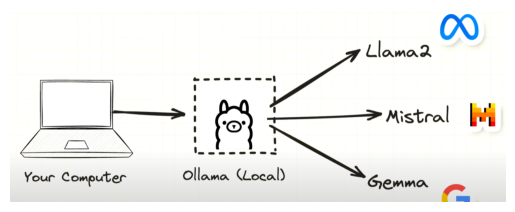

In [8]:
# Add  image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(repo_dir / 'notes' / 'ollama.png')
# img = img.resize((15, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes

plt.show()


In [61]:
from langchain_community.llms import Ollama

In [62]:
llm = Ollama(model="llama3.1:latest")
llm.invoke("Hello, what is 5+10?")

'The answer to 5 + 10 is:\n\n15!\n\nWould you like me to help with anything else?'

Example prompt:

In [65]:
prompt = """Can you add an appropriate category to the my expenses. Example: Spotify AB by Adyen --- Entertainment. 
Make sure you follow the template of three dashes (---) seperating the input expense and your predicted category.
I am located in Toronto, Canada. 
Categories should be less than 5 words. 
Here is the one you need to categorize: """ + unique_transactions[0]
prompt

'Can you add an appropriate category to the my expenses. Example: Spotify AB by Adyen --- Entertainment. \nMake sure you follow the template of three dashes (---) seperating the input expense and your predicted category.\nI am located in Toronto, Canada. \nCategories should be less than 5 words. \nHere is the one you need to categorize: AMZN Mktp CA'

* Why 3 dashes? Some transactions have a dash in the description. So easy to split later.
* Why mention the city - make it more relevant. Sometime LLM mixed CA for California instead of Canada

In [66]:
categories_df_all = pd.DataFrame(columns = ['Transaction vs category', 'Transaction', 'Category'])
for inx, transaction in enumerate(unique_transactions):
    try:
        prompt = """Can you add an appropriate category to the my expenses. Example: Spotify AB by Adyen --- Entertainment. 
        Make sure you follow the template of three dashes (---) seperating the input expense and your predicted category.
        I am located in Toronto, Canada. 
        Categories should be less than 5 words. 
        Here is the one you need to categorize: """ + transaction
        
        response = llm.invoke(prompt)
        response = response.split('\n')
        print(response)
    
        categories_item = pd.DataFrame({'Transaction vs category': response})
        categories_item[['Transaction', 'Category']] = categories_item['Transaction vs category'].str.split('---', expand=True)
        categories_df_all = pd.concat([categories_df_all, categories_item], ignore_index=True)
        break
    except Exception as e:
        print('\nError at : ', inx, transaction)
        print('\t', e, '\n')
        
    

['Here is the categorized expense:', '', 'AMZN Mktp CA --- Online Shopping']


* Why `try-catch` block? Sometimes the llm doesnt return a proper category. In such case the splitting will result in an error
* You can remove the break command to run this for all transactions.
* Further to save time, pass in multiple transactions instead of 1 to categories in 1 prompt.

In [67]:
categories_df_all

,Transaction vs category,Transaction,Category
0,Here is the categorized expense:,Here is the categorized expense:,None
1,,,None
2,AMZN Mktp CA --- Online Shopping,AMZN Mktp CA,Online Shopping


Remove unnecessary rows, where `Category` == None